In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [ ]:
# load data
model_mapping = {
    "ViT-T": "Tiny",
    "ViT-S": "Small",
    "ViT-B": "Base",
    "ViT-L": "Large",
    "ViT-H": "Huge",
}

# mae
df_mae = pd.read_csv("./result_all/mae_biovfm_v2_best.csv")
df_mae['name'] = df_mae['name'].apply(lambda x: x.replace('MAE@', '').split(' ')[0])
df_mae['name'] = df_mae['name'].apply(lambda x: model_mapping[x])
# dino
df_dino = pd.read_csv("./result_all/dinov2_biovfm_v2_best.csv")
df_dino['name'] = df_dino['name'].apply(lambda x: x.replace('DINOV2@', '').split(' ')[0])
df_dino['name'] = df_dino['name'].apply(lambda x: model_mapping[x])
if df_dino.isnull().values.any():
    print("Interpolating missing values")
    df_dino.interpolate(method='linear', inplace=True)
# biomedclip
df_biomedclip = pd.read_csv("./result_all/biomedclip.csv")

In [3]:
# compute mean values
auc_list = ['dermamnist_auc', 'pneumoniamnist_auc', 'breastmnist_auc', 'pathmnist_auc', 'chestmnist_auc', 'octmnist_auc', 'retinamnist_auc', 'bloodmnist_auc', 'tissuemnist_auc', 'organamnist_auc', 'organcmnist_auc', 'organsmnist_auc']
acc_list = ['dermamnist_acc', 'pneumoniamnist_acc', 'breastmnist_acc', 'pathmnist_acc', 'chestmnist_acc', 'octmnist_acc', 'retinamnist_acc', 'bloodmnist_acc', 'tissuemnist_acc', 'organamnist_acc', 'organcmnist_acc', 'organsmnist_acc']
auc_list = ['dermamnist_auc', 'pneumoniamnist_auc', 'breastmnist_auc', 'chestmnist_auc', 'octmnist_auc', 'retinamnist_auc', 'bloodmnist_auc', 'tissuemnist_auc', 'organamnist_auc', 'organcmnist_auc', 'organsmnist_auc', 'pathmnist_auc', ]
acc_list = ['dermamnist_acc', 'pneumoniamnist_acc', 'breastmnist_acc', 'chestmnist_acc', 'octmnist_acc', 'retinamnist_acc', 'bloodmnist_acc', 'tissuemnist_acc', 'organamnist_acc', 'organcmnist_acc', 'organsmnist_acc', 'pathmnist_acc', ]
df_dino['mean_auc'] = df_dino[auc_list].mean(axis=1)
df_dino['mean_acc'] = df_dino[acc_list].mean(axis=1)
df_mae['mean_auc'] = df_mae[auc_list].mean(axis=1)
df_mae['mean_acc'] = df_mae[acc_list].mean(axis=1)
df_biomedclip['mean_auc'] = df_biomedclip[auc_list].mean(axis=1)
df_biomedclip['mean_acc'] = df_biomedclip[acc_list].mean(axis=1)

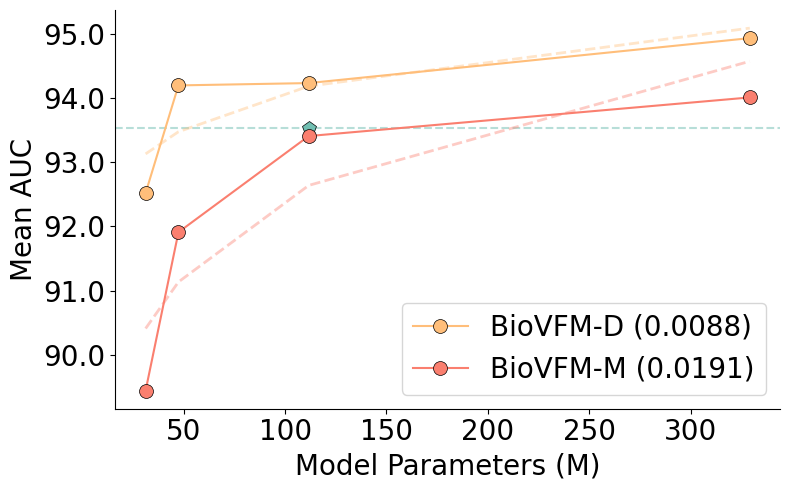

In [4]:
def map_dataset_name(x):
    new_name = x.split('_')[0].capitalize().replace('_auc', '').replace('mnist', "MNIST")
    if 'organ' in new_name.lower():
        # capitalize the 6th character
        new_name = new_name[:5] + new_name[5].upper() + new_name[6:]
    return new_name


def draw_comparison_plot(
        df_dino, df_mae, ax, col, 
        fit_type='power_ref', show_baseline=True, show_slope=False,
        fontsize=20, markersize=10, linewidth=2,
        
    ):

    # convert value
    df_dino = df_dino * 100
    df_mae = df_mae * 100

    model_params = [31.2, 47.4, 111.66, 329.24]
    if fit_type == "power_ref":
        # ref: https://github.com/formll/resolving-scaling-law-discrepancies/blob/b20ccd4300de08eeafcd39edef63540a71d2fcd4/analysis.py#L61-L84
        mae_x_data = np.log(np.array(model_params)).reshape(-1, 1)
        mae_y_data = np.log(df_mae[col])
        mae_clf = LinearRegression().fit(mae_x_data, mae_y_data)
        mae_slope, mae_intercept = mae_clf.coef_[0], mae_clf.intercept_
        mae_fit = np.exp(mae_intercept) * model_params ** mae_slope
        dino_x_data = np.log(np.array(model_params)).reshape(-1, 1)
        dino_y_data = np.log(df_dino[col])
        dino_clf = LinearRegression().fit(dino_x_data, dino_y_data)
        dino_slope, dino_intercept = dino_clf.coef_[0], dino_clf.intercept_
        dino_fit = np.exp(dino_intercept) * model_params ** dino_slope
    else:
        raise ValueError(f"Unknown fit type: {fit_type}")

    # compare mean auc and acc of dino and mae
    dino_color = '#FFBE7A'
    mae_color = '#FA7F6F'
    biomedclip_color = '#71BFB2'

    # BiomedCLIP
    ax.axhline(y=df_biomedclip[col].values[0] * 100, color=biomedclip_color, linestyle='--', alpha=0.5)
    ax.plot(111.66, df_biomedclip[col].values[0] * 100, 'p', color=biomedclip_color, markersize=markersize, markeredgecolor='black', markeredgewidth=0.5, markerfacecolor=biomedclip_color)
    # BioVFM
    ax.plot(model_params, df_dino[col], 'o-', label=f'BioVFM-D ({dino_slope:.4f})', color=dino_color, alpha=1, markersize=markersize, markeredgecolor='black', markeredgewidth=0.5, markerfacecolor=dino_color)
    ax.plot(model_params, df_mae[col], 'o-', label=f'BioVFM-M ({mae_slope:.4f})', color=mae_color, alpha=1, markersize=markersize, markeredgecolor='black', markeredgewidth=0.5, markerfacecolor=mae_color)
    # BioVFM (fitted)
    ax.plot(model_params, dino_fit, '--', color=dino_color, alpha=0.4, linewidth=2)
    ax.plot(model_params, mae_fit, '--', color=mae_color, alpha=0.4, linewidth=2)

    ax.set_xlabel('Model Parameters (M)', fontsize=fontsize)
    colname = map_dataset_name(col)
    ax.set_ylabel(f'{colname} AUC', fontsize=fontsize)
    ax.legend(loc='lower right', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return mae_slope, dino_slope

fig, ax = plt.subplots(1, 1, figsize=(8,5))
draw_comparison_plot(df_dino, df_mae, ax, 'mean_auc', fit_type='power_ref', show_baseline=True, show_slope=True)

# save figure
plt.tight_layout()
plt.show()

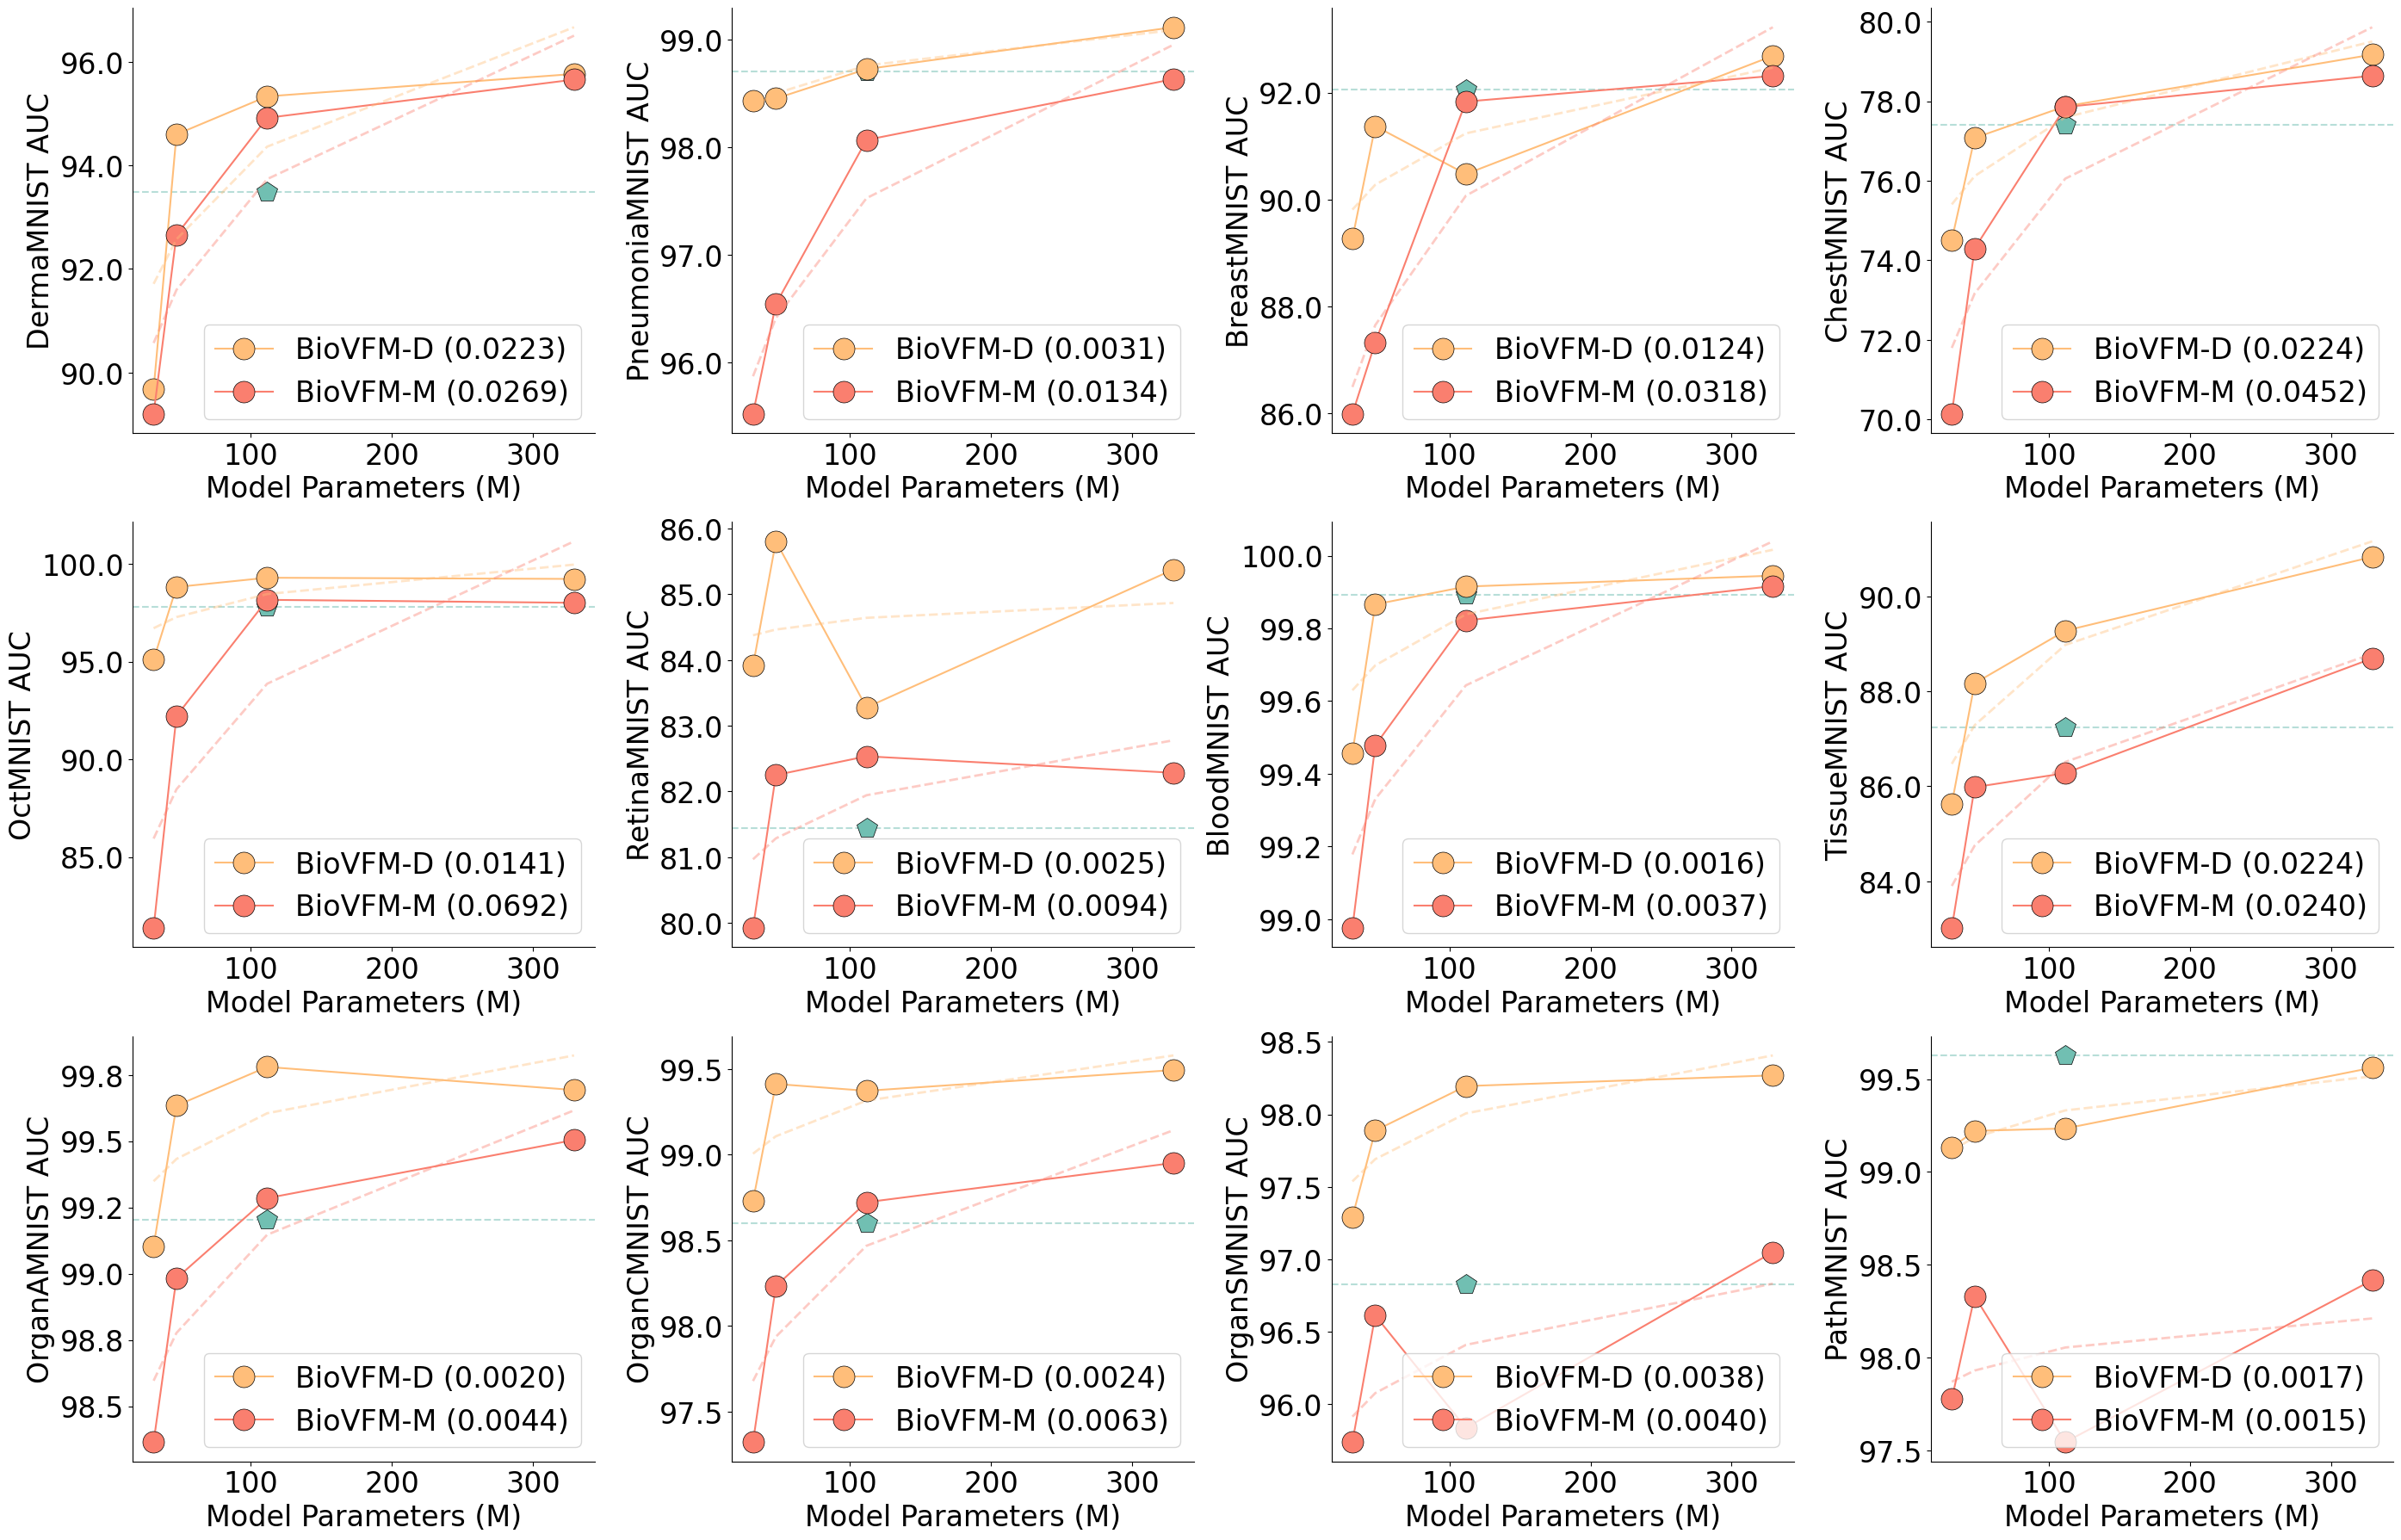

In [5]:
fig, ax = plt.subplots(3, 4, figsize=(28, 18))
fig.subplots_adjust(wspace=0.4, hspace=0.25)
ax = ax.flatten()

mae_slope_list = []
dino_slope_list = []
for i, col in enumerate(auc_list):
    mae_slope, dino_slope = draw_comparison_plot(
        df_dino, df_mae, ax[i], col, fit_type='power_ref',
        fontsize=24, markersize=18, linewidth=2, show_slope=True,
        )
    mae_slope_list.append(mae_slope)
    dino_slope_list.append(dino_slope)

plt.tight_layout()
plt.show()

In [6]:
auc_df = pd.DataFrame({
    'dataset': auc_list,
    'mae_slope': mae_slope_list,
    'dino_slope': dino_slope_list,
})
auc_df['dataset'] = auc_df['dataset'].apply(map_dataset_name)

# sort by dino slope
auc_df = auc_df.sort_values('dino_slope', ascending=False)
auc_df['color'] = sns.color_palette('RdPu_r', n_colors=len(auc_df))


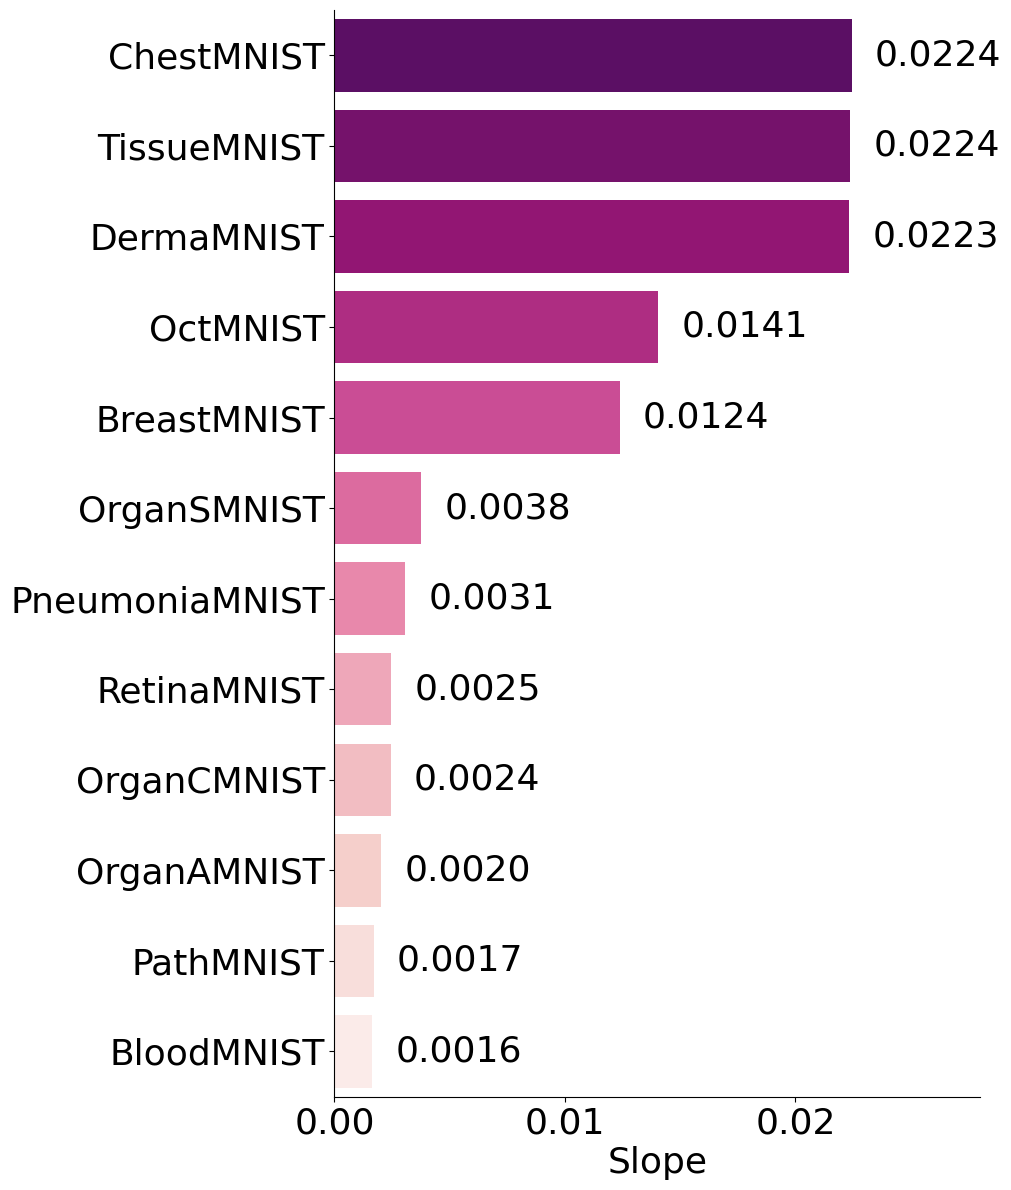

In [7]:
# DINO slope
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
auc_df = auc_df.sort_values('dino_slope', ascending=False)
sns.barplot(x='dino_slope', y='dataset', data=auc_df, ax=ax, orient='h', palette=auc_df['color'])
for i, v in enumerate(auc_df['dino_slope']):
    ax.text(v + 0.001, i, f'{v:.4f}', color='black', va='center', fontsize=26)
ax.set_xlabel('Slope', fontsize=26)
ax.set_ylabel('', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=26)
ax.set_xlim(0., 0.028)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

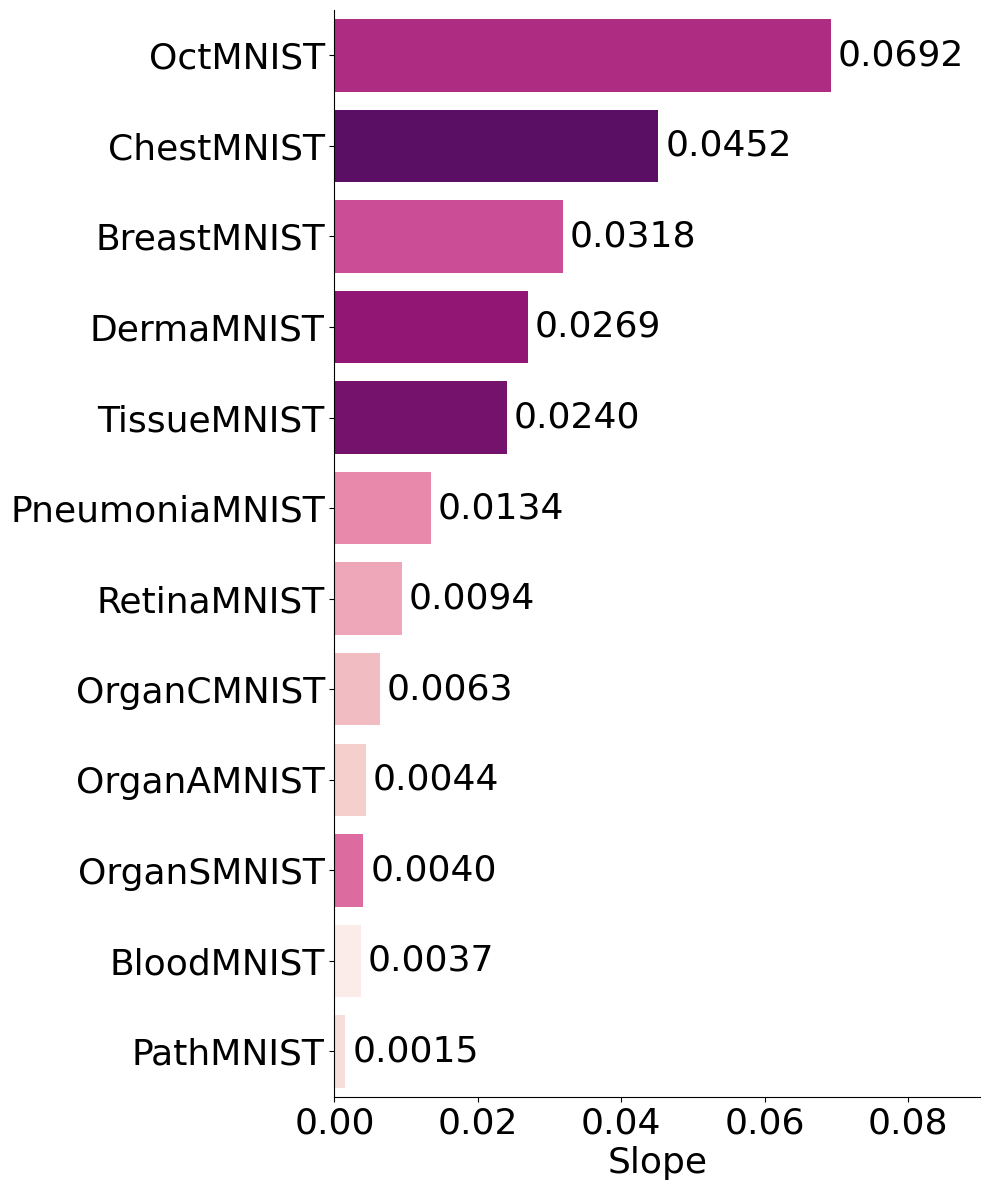

In [8]:
# MAE slope
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
auc_df = auc_df.sort_values('mae_slope', ascending=False)
sns.barplot(x='mae_slope', y='dataset', data=auc_df, ax=ax, orient='h', palette=auc_df['color'])
for i, v in enumerate(auc_df['mae_slope']):
    ax.text(v + 0.001, i, f'{v:.4f}', color='black', va='center', fontsize=26)
ax.set_xlabel('Slope', fontsize=26)
ax.set_ylabel('', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=26)
ax.set_xlim(0., 0.09)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

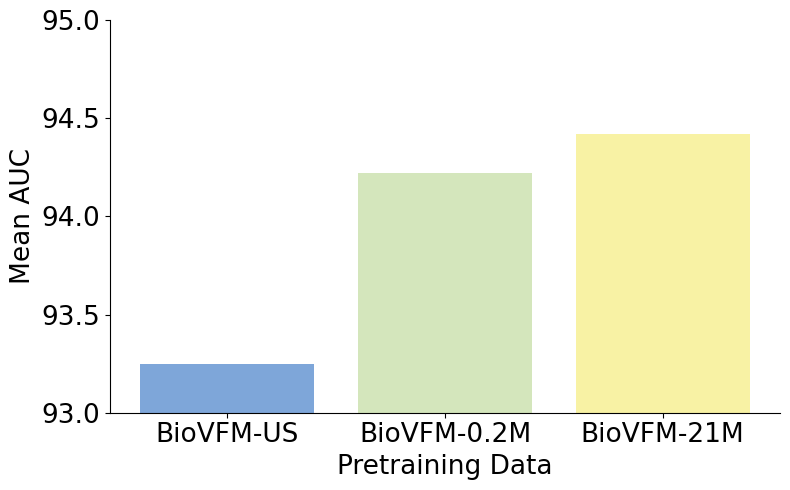

In [9]:
values = [93.25, 94.22, 94.42]
names = ['BioVFM-US', 'BioVFM-0.2M', 'BioVFM-21M']

# draw the bar chart
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#7EA6D9', '#D4E6BC', '#F8F2A4']
ax.bar(names, values, color=colors)


fontsize = 19
ax.tick_params(axis='both', which='major', labelsize=fontsize)

ax.set_xlabel('Pretraining Data', fontsize=fontsize)
ax.set_ylabel('Mean AUC', fontsize=fontsize)

ax.set_ylim(93, 95)
# Format y-axis labels
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

/var/folders/t8/1brr13js3mbdjk038hh9ppxm0000gp/T/ipykernel_64734/1462665433.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat_all = df.corr(corr_method)


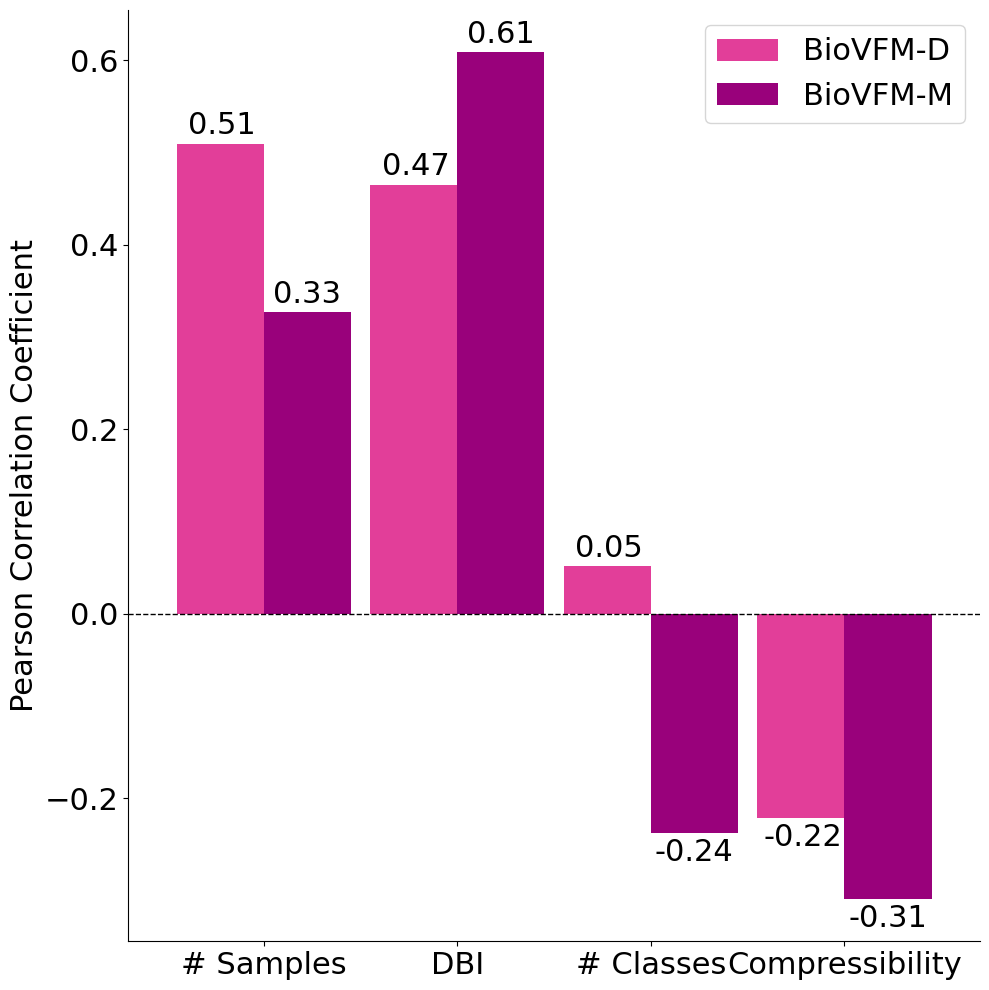

In [10]:
df = pd.read_csv("result_all/medmnist_bestmodel_power.csv")

intrest_factors = ['num_classes', 'num_samples', 'entropy', 'gzip_median', 'dbi']
target_factors = ['dino_slope', 'mae_slope']

intrest_factors = {
    'num_classes': '# Classes', 
    'num_samples': '# Samples',
    'gzip_median': 'Compressibility',
    'dbi': 'DBI',
}

target_factors = {
    'dino_slope': 'BioVFM-D', 
    'mae_slope': 'BioVFM-M',
}


corr_method = 'pearson'

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

corr_mat_all = df.corr(corr_method)

intrest_corr_mat = corr_mat_all[intrest_factors.keys()].loc[target_factors.keys()].T
# sort the correlation matrix by the absolute value of the correlation on dino_slope
intrest_corr_mat = intrest_corr_mat.reindex(intrest_corr_mat['dino_slope'].sort_values(ascending=False).index)

# rename the rows and columns by intrest_factors and target_factors
intrest_corr_mat = intrest_corr_mat.rename(index=intrest_factors, columns=target_factors)
intrest_corr_mat
# draw the grouped bar plot
cmap = mpl.cm.RdPu
intrest_corr_mat.plot(kind='bar', ax=ax, rot=0, fontsize=22, color=[cmap(0.6), cmap(0.8)], width=0.9)
# add the correlation values on top of the bars
for i, v in enumerate(intrest_corr_mat['BioVFM-D']):
    ax.text(
        i-0.39 if v >= 0 else i-0.42,
        v+0.01 if v >= 0 else v-0.03,
        f"{v:.2f}", fontsize=22,
    )
for i, v in enumerate(intrest_corr_mat['BioVFM-M']):
    ax.text(
        i+0.05 if v >= 0 else i+0.02,
        v+0.01 if v >= 0 else v-0.03, 
        f"{v:.2f}", fontsize=22,
    )

ax.set_ylabel('Pearson Correlation Coefficient', fontsize=22)
ax.set_xlabel('')
ax.legend(fontsize=22)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# add horizontal line at y=0
ax.axhline(0, color='black', linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()